# Customer Segmentation

### Importing Data

In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/processed/rfm_feature_engineered.csv')
df.head()

,customer_id,recency,frequency,price_sum
0,1,-455,1,11.77
1,2,-444,2,89.00
2,3,-127,5,139.47
3,4,-110,4,100.50
4,5,-88,11,385.61


### Clustering based on RFM features

**Scaling Features**

In [125]:
segmentation_features = ['recency', 'frequency', 'price_sum']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[segmentation_features])
scaled_features

array([[-1.01200742, -0.42059144, -0.40830018],
       [-0.93848969, -0.1741687 , -0.03834136],
       [ 1.18015764,  0.5650995 ,  0.20342766],
       ...,
       [-0.27014668,  0.07225403,  0.11830312],
       [-0.45728272, -0.42059144, -0.34137898],
       [-0.45059929, -0.1741687 , -0.01400638]])

In [126]:
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=['recency', 'frequency', 'price_sum'])
scaled_df.head(3)

,recency,frequency,price_sum
0,-1.012007,-0.420591,-0.408300
1,-0.938490,-0.174169,-0.038341
2,1.180158,0.565099,0.203428


**Visualizing Scaled Features Distribution**

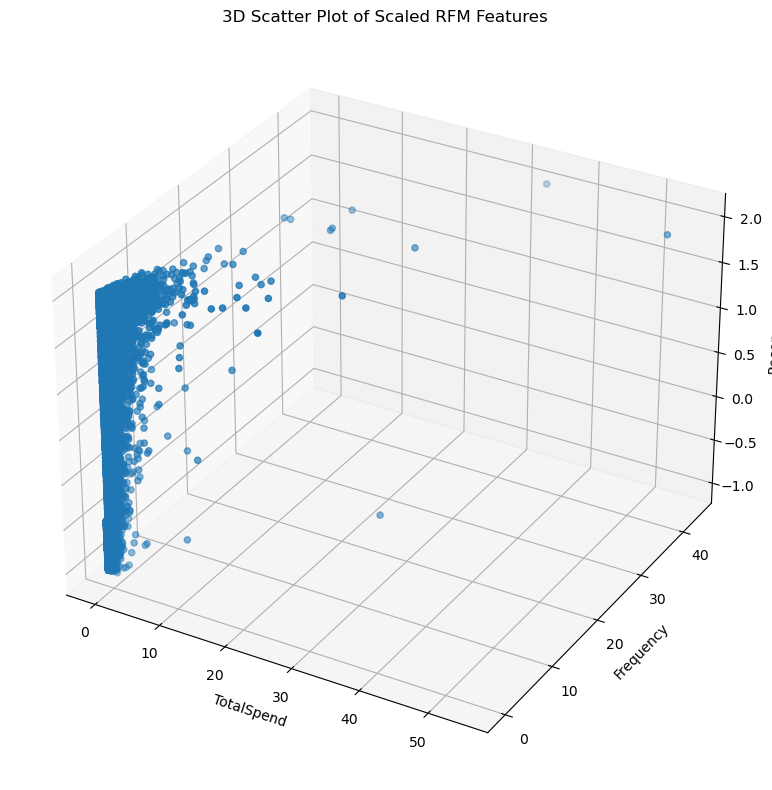

In [128]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(
  scaled_df['price_sum'],
  scaled_df['frequency'],
  scaled_df['recency']
)

ax.set_xlabel("TotalSpend")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title('3D Scatter Plot of Scaled RFM Features')

plt.tight_layout()
plt.show()

**Finding out Optimal Cluster Number**

In [100]:
inertia = [] # sum of square error
silhouette_scores = [] #[-1,1] high means low overlap
K_range = range(2, 11)

for k in K_range:
  kmean = KMeans(n_clusters=k, max_iter=1000, n_init='auto', random_state=42)
  cluster_labels = kmean.fit_predict(scaled_df)
  sil_score = silhouette_score(scaled_df, cluster_labels)
  silhouette_scores.append(sil_score)
  inertia.append(kmean.inertia_)

In [101]:
silhouette_scores

[0.9331687926659219,
 0.6757407995922675,
 0.6802589946661545,
 0.676503019624033,
 0.5878062478418837,
 0.5878129950714697,
 0.5862054781368525,
 0.5678664696132771,
 0.570253696036936]

**Visualizing Elbow Curve and Silhouette Scores**

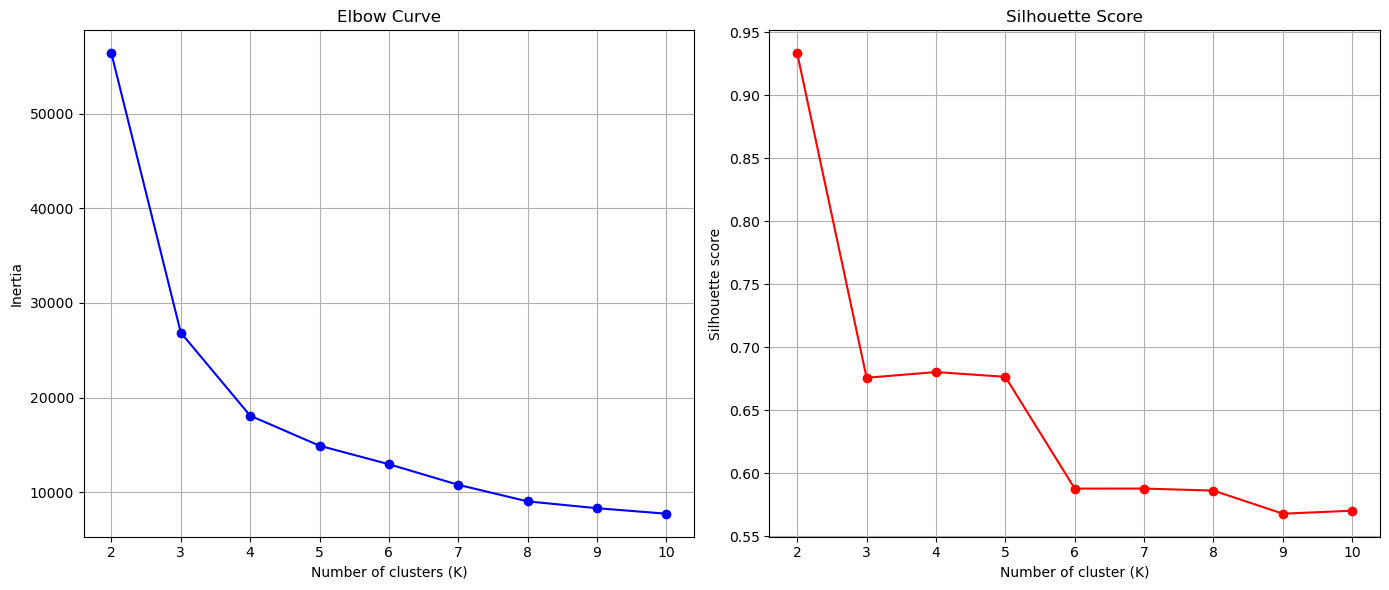

In [102]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.title('Elbow Curve')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of cluster (K)')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

**Visualizing Rate of Inertia Change**

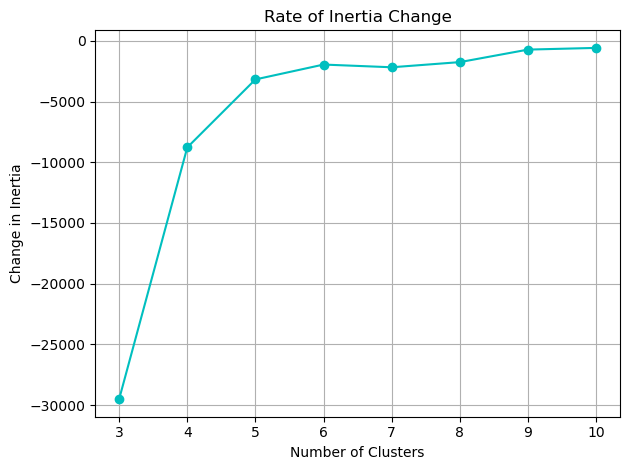

In [103]:
inertia_changes = np.diff(inertia)
plt.plot(K_range[1:], inertia_changes, 'co-')
plt.xlabel('Number of Clusters')
plt.ylabel('Change in Inertia')
plt.title('Rate of Inertia Change')
plt.tight_layout()
plt.grid(True)
plt.show()

**Initializing KMeans Object with Optimum Cluster Number-4**

In [154]:
segmented_df = df.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
segmented_df['segment'] = kmeans.fit_predict(scaled_df)
cluster_labels = kmeans.labels_
optimum_inertia = kmeans.inertia_

**Removing Dimentions to 2 using PCA**

In [150]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
pca_df.head()

,PCA1,PCA2
0,-1.008013,0.582971
1,-0.594271,0.746945
2,1.058679,-0.788221
3,0.847072,-1.028267
4,2.827143,-0.128760


In [146]:
pca_df['cluster'] = cluster_labels

In [147]:
pca_df.head()

,PCA1,PCA2,cluster
0,-1.008013,0.582971,1
1,-0.594271,0.746945,1
2,1.058679,-0.788221,0
3,0.847072,-1.028267,0
4,2.827143,-0.128760,0


**Visualizing Segmentation using 2 Principal Components**

In [135]:
fig = px.scatter(x=pca_df['PCA1'], y=pca_df['PCA2'], color=pca_df['cluster'], size=pca_df['cluster'], title='Clustering using K-Means Algorithm')
fig.update_layout(
  xaxis_title='PCA1',
  yaxis_title='PCA2',
  title='Customer Segmentation'
)
fig.show()

In [155]:
segmented_df.groupby('segment')['recency', 'frequency', 'price_sum'].mean()

,recency,frequency,price_sum
segment,,,
0,-100.982143,4.523910,155.940593
1,-396.212642,1.351826,41.441386
2,-47.800609,16.444444,806.178737
3,-39.200000,107.300000,5097.903000


**Adding Cluster Labels**

In [156]:
def get_label(row):
  if row['segment'] == 0:
    return 'Average'
  elif row['segment'] == 1:
    return 'Losing'
  elif row['segment'] == 2:
    return 'Loyal'
  else:
    return 'VIP'

segmented_df['segment_label'] = segmented_df.apply(get_label, axis='columns')

In [157]:
segmented_df.head()

,customer_id,recency,frequency,price_sum,segment,segment_label
0,1,-455,1,11.77,1,Losing
1,2,-444,2,89.00,1,Losing
2,3,-127,5,139.47,0,Average
3,4,-110,4,100.50,0,Average
4,5,-88,11,385.61,0,Average


In [158]:
segmented_df['segment_label'].value_counts()

Losing     16295
Average     6608
Loyal        657
VIP           10
Name: segment_label, dtype: int64

### Exporting Data

In [159]:
segmented_df.to_csv('../data/processed/segmented_df.csv', index=False)